# Cluster the Face Images

## Import Image Annotations

In [76]:
import json
import os
import cv2
import numpy as np

In [2]:
# load the json file which has annotations
json_file = 'face_annotations.json'

data = []
with open(json_file, 'r') as file:
    data = json.load(file)

In [82]:
#data.keys()

In [13]:
data['img_001.jpg52370']

{'filename': 'img_001.jpg',
 'size': 52370,
 'regions': [{'shape_attributes': {'name': 'rect',
    'x': 66,
    'y': 53,
    'width': 74,
    'height': 125},
   'region_attributes': {'class': 'Right'}},
  {'shape_attributes': {'name': 'rect',
    'x': 232,
    'y': 36,
    'width': 68,
    'height': 125},
   'region_attributes': {'class': 'DownLeft'}}],
 'file_attributes': {'caption': '', 'public_domain': 'no', 'image_url': ''}}

In [19]:
data['img_001.jpg52370']['regions']

[{'shape_attributes': {'name': 'rect',
   'x': 66,
   'y': 53,
   'width': 74,
   'height': 125},
  'region_attributes': {'class': 'Right'}},
 {'shape_attributes': {'name': 'rect',
   'x': 232,
   'y': 36,
   'width': 68,
   'height': 125},
  'region_attributes': {'class': 'DownLeft'}}]

In [23]:
data['img_001.jpg52370']['regions'][0]['shape_attributes']

{'name': 'rect', 'x': 66, 'y': 53, 'width': 74, 'height': 125}

In [24]:
data['img_001.jpg52370']['regions'][0]['shape_attributes']['width']

74

In [29]:
## Extract the width and height from image annotations
X = [] 

for imgkey, imgval in data.items():
    # go over each region 
    for reg in imgval['regions']:
        # from shape attributes
        shape = reg['shape_attributes']
        # get the width and height
        temp_list = [shape['width'], shape['height']]
        X.append(temp_list)
        
        

In [31]:
X[0:5]

[[74, 125], [68, 125], [44, 71], [39, 70], [69, 94]]

In [32]:
len(X)

220

In [37]:
# convert into np array - each element is width, height
X = np.reshape(X, (-1, 2))

In [38]:
X[0:5]

array([[ 74, 125],
       [ 68, 125],
       [ 44,  71],
       [ 39,  70],
       [ 69,  94]])

In [39]:
## convert the values(width, height) to scale 0 to 1
## all images are of resolution 400x400
X = X/400

In [40]:
X[0:5]

array([[0.185 , 0.3125],
       [0.17  , 0.3125],
       [0.11  , 0.1775],
       [0.0975, 0.175 ],
       [0.1725, 0.235 ]])

In [41]:
## get the log value of width and height
log_X = np.log(X)

In [42]:
log_X[0:5]

array([[-1.68739945, -1.16315081],
       [-1.77195684, -1.16315081],
       [-2.20727491, -1.72878467],
       [-2.3279029 , -1.74296931],
       [-1.75735804, -1.44816976]])

## Plot Width vs Height

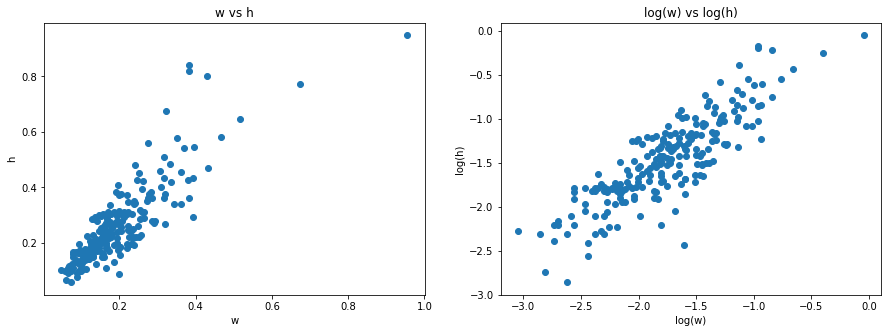

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2,figsize=(15,5))

# regular width vs height
axs[0].plot(X[:, 0], X[:, 1], 'o')
axs[0].set_title('w vs h')
axs[0].set_ylabel('h')
axs[0].set_xlabel('w')

# plot the log scale values of width and height
axs[1].plot(log_X[:, 0], log_X[:, 1], 'o')
axs[1].set_title('log(w) vs log(h)')
axs[1].set_ylabel('log(h)')
axs[1].set_xlabel('log(w)')
plt.show()

## Clustering using KMeans

In [46]:
from sklearn.cluster import KMeans

In [48]:
#?KMeans

In [49]:
kmeans = KMeans(n_clusters=4, init="k-means++", n_init=10, max_iter=300, tol=0.0001).fit(X)
log_kmeans = KMeans(n_clusters=4, init="k-means++", n_init=10, max_iter=300, tol=0.0001).fit(log_X)

In [52]:
print(kmeans.n_clusters)
print(kmeans.cluster_centers_)

4
[[0.11585227 0.1525    ]
 [0.32204545 0.43795455]
 [0.20005376 0.26768817]
 [0.55666667 0.80458333]]


In [54]:
## get the clusters for each element
y_pred, ly_pred = kmeans.predict(X), log_kmeans.predict(log_X)

## Plot Clusters

In [58]:
#?plt.scatter

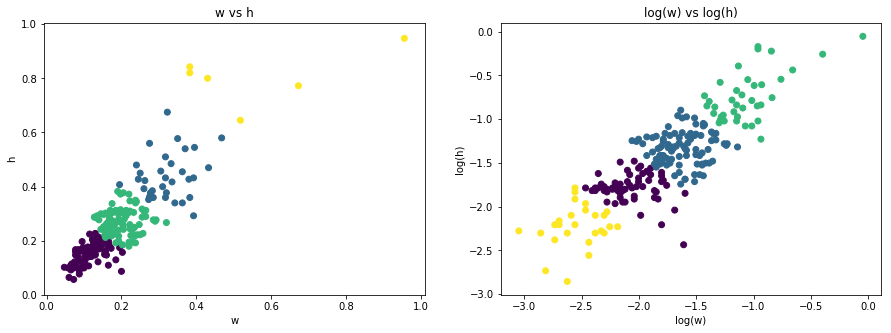

In [59]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

# regular width vs height
axs[0].scatter(X[:, 0], X[:, 1], c=y_pred)
axs[0].set_title('w vs h')
axs[0].set_ylabel('h')
axs[0].set_xlabel('w')

# plot the log scale values of width and height
axs[1].scatter(log_X[:, 0], log_X[:, 1], c=ly_pred)
axs[1].set_title('log(w) vs log(h)')
axs[1].set_ylabel('log(h)')
axs[1].set_xlabel('log(w)')
plt.show()

## Choose Best Bounding Boxes

In [60]:
kmeans.cluster_centers_*400

array([[ 46.34090909,  61.        ],
       [128.81818182, 175.18181818],
       [ 80.02150538, 107.07526882],
       [222.66666667, 321.83333333]])

In [62]:
# these are log values, so use exp to get original value and multiply by 400
np.exp(log_kmeans.cluster_centers_)*400

array([[ 50.68576131,  67.09112992],
       [ 78.51575295, 105.52204114],
       [138.89936277, 190.13431528],
       [ 31.77059357,  43.23562061]])

In [63]:
## from the plot, the value with log scale clustered better.
## so,use that bounding box.
b_boxes = np.exp(log_kmeans.cluster_centers_)*400

## Visualize with Random Images

In [64]:
import matplotlib.patches as patches

In [72]:
def plot_image(img_db, bb):
    # pick random image from 0 to 99
    idx = np.random.randint(0, 99)
    
    key = list(img_db.keys())[idx]
    imgval = img_db[key]
    
    # get source path
    ps = os.path.join("images", imgval["filename"])
    
    # read the image
    img = cv2.imread(ps)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # get the current figure
    fig = plt.gcf()
    
    fig.set_size_inches(12, 12)
    plt.imshow(img)
    
    ax = fig.get_axes()[0]
    
    for rgnd in imgval['regions']:
        shape = rgnd['shape_attributes']
        # get the shape attributes
        x, y, w, h = shape['x'], shape['y'], shape['width'], shape['height']
        
        # create patch image
        rect = patches.Rectangle((x, y), w, h, linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        
        cx, cy = (x + w/2), (y + h/2)
        num_bb = len(bb)
        # different colors for each bounding box
        c = ['g', 'b', 'm', 'c']
        for i in range(num_bb):
            w, h = bb[i, 0], bb[i, 1]
            x, y = cx - w/2, cy - h/2
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=c[i], facecolor='none')
            ax.add_patch(rect)
    plt.show()

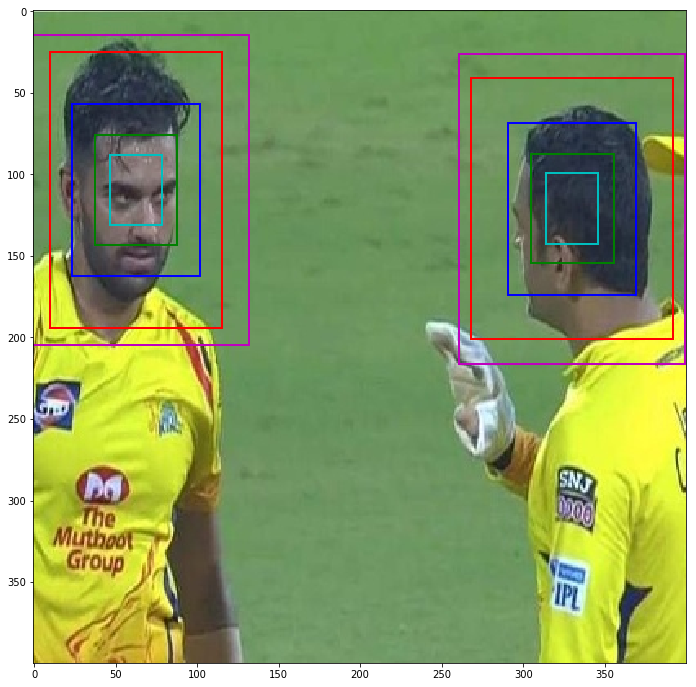

In [77]:
plot_image(data, b_boxes)

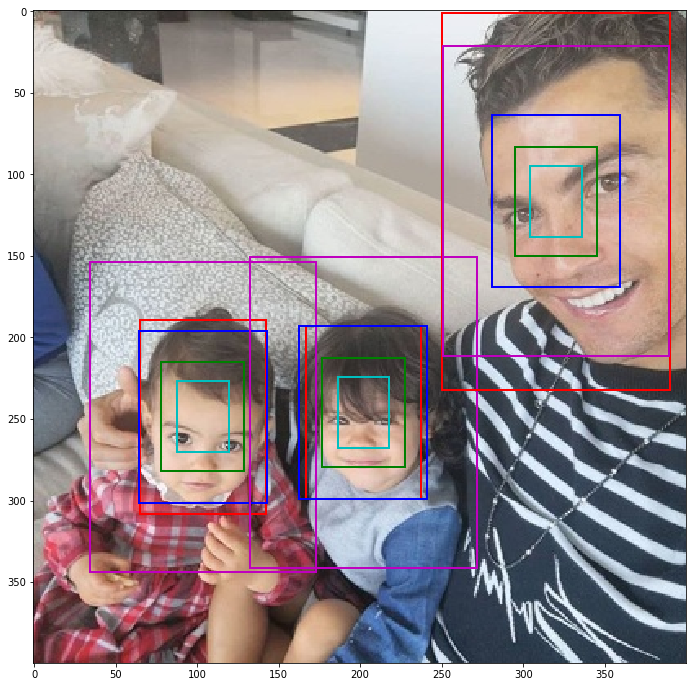

In [78]:
plot_image(data, b_boxes)

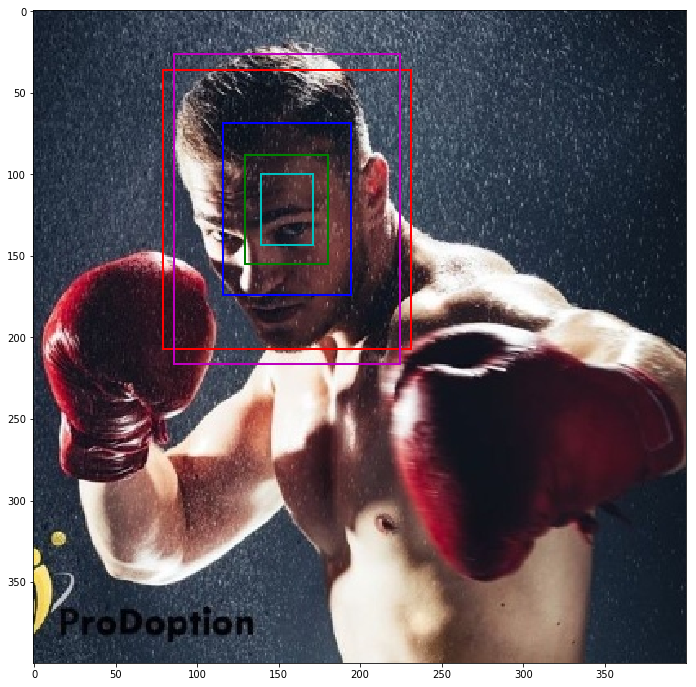

In [79]:
plot_image(data, b_boxes)

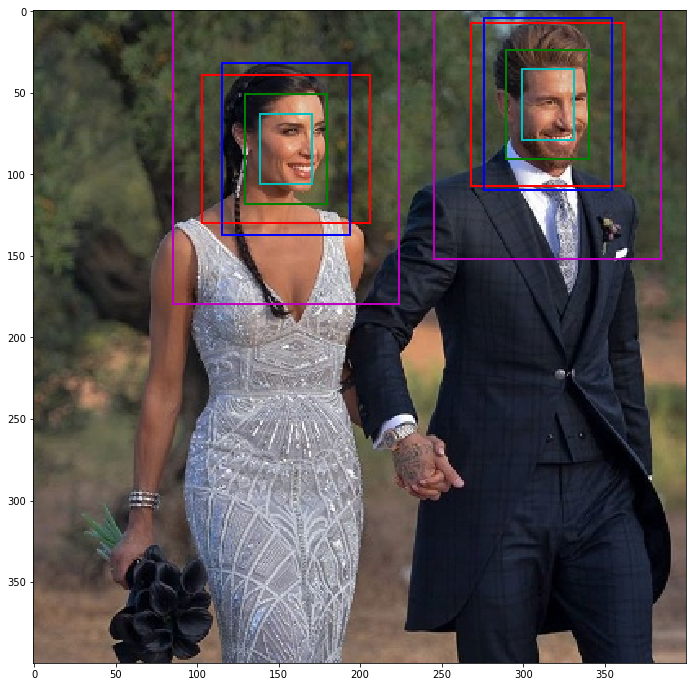

In [80]:
plot_image(data, b_boxes)

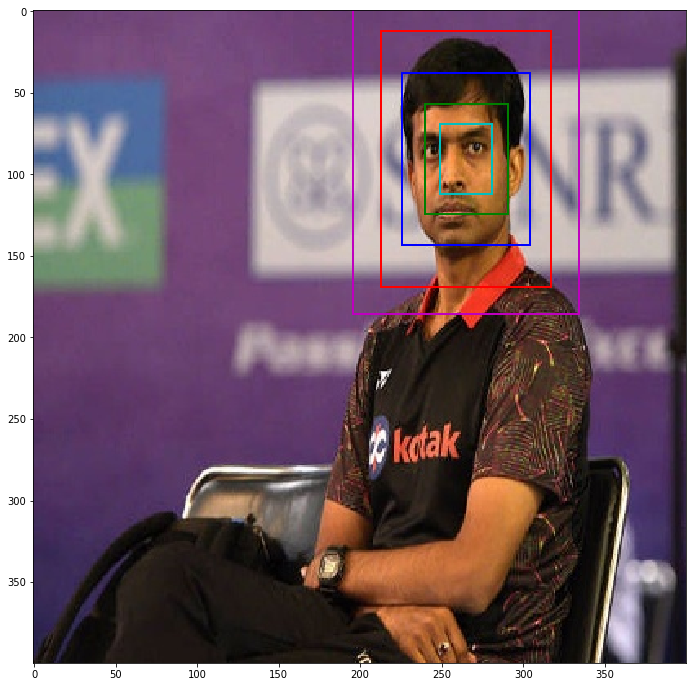

In [81]:
plot_image(data, b_boxes)